# **Quantitative Economics**

**Probelem Set 10**

**Parham Mohammadi-401206677**

**Sana Rashidi-401211522**

# **Library**

In [ ]:
import numbers
from textwrap import dedent

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import solve

# **1. Recursive Dynamic Equilibrium**

Considering that the function F is quadratic, it can be said that the policy function is linear and the value function is quadratic.


Therefore, we use the LQ method to solve this problem.

Considering that there is $\beta$ in this problem and there is a shock in the state function, we should use the general form of stochastic optimal linear quadraric problem, whose general form is as follows:



$$
\begin{aligned}
V(x) &=\max _{\left\{u_{t}\right\}}-E_{0} \sum_{t=0}^{\infty} \beta^{t}\left(x_{t}^{\prime} R x_{t}+u_{t}^{\prime} Q u_{t}\right) \\
\text { s.t. } x_{t+1} &=A x_{t}+B u_{t}+C \varepsilon_{t+1}
\end{aligned}
$$
where $\varepsilon_{t+1}$ is an $(n \times 1)$ vector of random variables that is independently and identically distributed according to the normal distribution with mean vector zero and covariance matrix.
$$
E \varepsilon_{t} \varepsilon_{t}^{\prime}=I
$$
  - Solution
$$
\begin{aligned}
V(x) &=-x^{\prime} P x-d \\
u &=-F x
\end{aligned}
$$
$$
\begin{aligned}
F &=\beta\left(Q+B^{\prime} P B\right)^{-1} B^{\prime} P A \\
P &=R+\beta A^{\prime} P A-\beta^{2} A^{\prime} P B\left(Q+\beta B^{\prime} P B\right)^{-1} B^{\prime} P A \\
d &=\beta(1-\beta)^{-1} \operatorname{tr}\left(P C C^{\prime}\right)
\end{aligned}
$$

First, we write a class to solve LQ problems and implement various tools and functions needed for it:

## **Utils**

In [ ]:
EPS = np.finfo(float).eps


def solve_discrete_riccati(A, B, Q, R, N=None, tolerance=1e-10, max_iter=500,
                           method="doubling"):

    methods = ['doubling', 'qz']
    if method not in methods:
        msg = "Check your method input. Should be {} or {}".format(*methods)
        raise ValueError(msg)

    # == Set up == #
    error = tolerance + 1
    fail_msg = "Convergence failed after {} iterations."

    # == Make sure that all array_likes are np arrays, two-dimensional == #
    A, B, Q, R = np.atleast_2d(A, B, Q, R)
    n, k = R.shape[0], Q.shape[0]
    I = np.identity(k)
    if N is None:
        N = np.zeros((n, k))
    else:
        N = np.atleast_2d(N)

    if method == 'qz':
        X = sp_solve_discrete_are(A, B, Q, R, s=N.T)
        return X

    # if method == 'doubling'
    # == Choose optimal value of gamma in R_hat = R + gamma B'B == #
    current_min = np.inf
    candidates = (0.01, 0.1, 0.25, 0.5, 1.0, 2.0, 10.0, 100.0, 10e5)
    BB = np.dot(B.T, B)
    BTA = np.dot(B.T, A)
    for gamma in candidates:
        Z = R + gamma * BB
        cn = np.linalg.cond(Z)
        if cn * EPS < 1:
            Q_tilde = - Q + np.dot(N.T, solve(Z, N + gamma * BTA, transposed=True)) + gamma * I
            G0 = np.dot(B, solve(Z, B.T))
            A0 = np.dot(I - gamma * G0, A) - np.dot(B, solve(Z, N))
            H0 = gamma * np.dot(A.T, A0) - Q_tilde
            f1 = np.linalg.cond(Z, np.inf)
            f2 = gamma * f1
            f3 = np.linalg.cond(I + np.dot(G0, H0))
            f_gamma = max(f1, f2, f3)
            if f_gamma < current_min:
                best_gamma = gamma
                current_min = f_gamma

    # == If no candidate successful then fail == #
    if current_min == np.inf:
        msg = "Unable to initialize routine due to ill conditioned arguments"
        raise ValueError(msg)

    gamma = best_gamma
    R_hat = R + gamma * BB

    # == Initial conditions == #
    Q_tilde = - Q + np.dot(N.T, solve(R_hat, N + gamma * BTA)) + gamma * I
    G0 = np.dot(B, solve(R_hat, B.T))
    A0 = np.dot(I - gamma * G0, A) - np.dot(B, solve(R_hat, N))
    H0 = gamma * np.dot(A.T, A0) - Q_tilde
    i = 1

    # == Main loop == #
    while error > tolerance:

        if i > max_iter:
            raise ValueError(fail_msg.format(i))

        else:
            A1 = np.dot(A0, solve(I + np.dot(G0, H0), A0))
            G1 = G0 + np.dot(np.dot(A0, G0), solve(I + np.dot(H0, G0), A0.T))
            H1 = H0 + np.dot(A0.T, solve(I + np.dot(H0, G0), np.dot(H0, A0)))

            error = np.max(np.abs(H1 - H0))
            A0 = A1
            G0 = G1
            H0 = H1
            i += 1

    return H1 + gamma * I  # Return X


def check_random_state(seed):

    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, (np.random.RandomState, np.random.Generator)):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)


class LQ:

    def __init__(self, Q, R, A, B, C=None, N=None, beta=1, T=None, Rf=None):
        # == Make sure all matrices can be treated as 2D arrays == #
        converter = lambda X: np.atleast_2d(np.asarray(X, dtype='float'))
        self.A, self.B, self.Q, self.R, self.N = list(map(converter,
                                                          (A, B, Q, R, N)))
        # == Record dimensions == #
        self.k, self.n = self.Q.shape[0], self.R.shape[0]

        self.beta = beta

        if C is None:
            # == If C not given, then model is deterministic. Set C=0. == #
            self.j = 1
            self.C = np.zeros((self.n, self.j))
        else:
            self.C = converter(C)
            self.j = self.C.shape[1]

        if N is None:
            # == No cross product term in payoff. Set N=0. == #
            self.N = np.zeros((self.k, self.n))

        if T:
            # == Model is finite horizon == #
            self.T = T
            self.Rf = np.asarray(Rf, dtype='float')
            self.P = self.Rf
            self.d = 0
        else:
            self.P = None
            self.d = None
            self.T = None

            if (self.C != 0).any() and beta >= 1:
                raise ValueError('beta must be strictly smaller than 1 if ' +
                    'T = None and C != 0.')

        self.F = None

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        m = """\
        Linear Quadratic control system
          - beta (discount parameter)       : {b}
          - T (time horizon)                : {t}
          - n (number of state variables)   : {n}
          - k (number of control variables) : {k}
          - j (number of shocks)            : {j}
        """
        t = "infinite" if self.T is None else self.T
        return dedent(m.format(b=self.beta, n=self.n, k=self.k, j=self.j,
                               t=t))

    def update_values(self):

        # === Simplify notation === #
        Q, R, A, B, N, C = self.Q, self.R, self.A, self.B, self.N, self.C
        P, d = self.P, self.d
        # == Some useful matrices == #
        S1 = Q + self.beta * np.dot(B.T, np.dot(P, B))
        S2 = self.beta * np.dot(B.T, np.dot(P, A)) + N
        S3 = self.beta * np.dot(A.T, np.dot(P, A))
        # == Compute F as (Q + B'PB)^{-1} (beta B'PA + N) == #
        self.F = solve(S1, S2)
        # === Shift P back in time one step == #
        new_P = R - np.dot(S2.T, self.F) + S3
        # == Recalling that trace(AB) = trace(BA) == #
        new_d = self.beta * (d + np.trace(np.dot(P, np.dot(C, C.T))))
        # == Set new state == #
        self.P, self.d = new_P, new_d

    def stationary_values(self, method='doubling'):

        # === simplify notation === #
        Q, R, A, B, N, C = self.Q, self.R, self.A, self.B, self.N, self.C

        # === solve Riccati equation, obtain P === #
        A0, B0 = np.sqrt(self.beta) * A, np.sqrt(self.beta) * B
        P = solve_discrete_riccati(A0, B0, R, Q, N, method=method)

        # == Compute F == #
        S1 = Q + self.beta * np.dot(B.T, np.dot(P, B))
        S2 = self.beta * np.dot(B.T, np.dot(P, A)) + N
        F = solve(S1, S2)

        # == Compute d == #
        if self.beta == 1:
            d = 0
        else:
            d = self.beta * np.trace(np.dot(P, np.dot(C, C.T))) / (1 - self.beta)

        # == Bind states and return values == #
        self.P, self.F, self.d = P, F, d

        return P, F, d

    def compute_sequence(self, x0, ts_length=None, method='doubling',
                         random_state=None):

        # === Simplify notation === #
        A, B, C = self.A, self.B, self.C

        # == Preliminaries, finite horizon case == #
        if self.T:
            T = self.T if not ts_length else min(ts_length, self.T)
            self.P, self.d = self.Rf, 0

        # == Preliminaries, infinite horizon case == #
        else:
            T = ts_length if ts_length else 100
            if self.P is None:
                self.stationary_values(method=method)

        # == Set up initial condition and arrays to store paths == #
        random_state = check_random_state(random_state)
        x0 = np.asarray(x0)
        x0 = x0.reshape(self.n, 1)  # Make sure x0 is a column vector
        x_path = np.empty((self.n, T+1))
        u_path = np.empty((self.k, T))
        w_path = random_state.standard_normal((self.j, T+1))
        Cw_path = np.dot(C, w_path)

        # == Compute and record the sequence of policies == #
        policies = []
        for t in range(T):
            if self.T:  # Finite horizon case
                self.update_values()
            policies.append(self.F)

        # == Use policy sequence to generate states and controls == #
        F = policies.pop()
        x_path[:, 0] = x0.flatten()
        u_path[:, 0] = - np.dot(F, x0).flatten()
        for t in range(1, T):
            F = policies.pop()
            Ax, Bu = np.dot(A, x_path[:, t-1]), np.dot(B, u_path[:, t-1])
            x_path[:, t] = Ax + Bu + Cw_path[:, t]
            u_path[:, t] = - np.dot(F, x_path[:, t])
        Ax, Bu = np.dot(A, x_path[:, T-1]), np.dot(B, u_path[:, T-1])
        x_path[:, T] = Ax + Bu + Cw_path[:, T]

        return x_path, u_path, w_path

## **1**

$$x_{t} = \begin{bmatrix} y_{t}\\Y_{t}\\1\end{bmatrix}   \qquad u_{t} = y_{t+1} - y_{t}$$
$$x^{\prime}Rx=(p-c)y=(A_{0}-A_{1}Y-c)y$$

$$\longrightarrow R=\begin{bmatrix} 0 & \frac{-A_{1}}{2} & \frac{A_{0}-c}{2}\\
                    \frac{-A_{1}}{2}& 0&0\\
                    \frac{A_{0}-c}{2}&0&0\end{bmatrix} $$
                    
$$u^{\prime}Qu=-0.5d(y_{t+1}-y_{t})^{2} \rightarrow Q=-0.5d$$
$$x^{\prime}Nu=-(y_{t+1}-y_{t})\rightarrow N=\begin{bmatrix} 0, &0,&-1\end{bmatrix} $$

In [ ]:
def LQDP(Q, R, A, B, C, N, beta):
    lq_dp = LQ(Q, R, A, B, C=C, N=N, beta=beta)
    P, F, d = lq_dp.stationary_values()
    return lq_dp, F

In [ ]:
beta = 0.95

H0 = 95.5
H1 = 0.95

A0 = 100
A1 = 0.05

c = 20

d = 15

sigma = 0.5

A = np.array(
    [
        [1, 0, 0],
        [0, H1, H0],
        [0, 0, 1]
    ]
)

B = np.array(
    [
        [1],
        [0],
        [0]
    ]
)

C = np.array(
    [
        [0],
        [sigma],
        [0]
    ]
)

R = np.array(
    [
        [0, -A1/2, (A0-c)/2],
        [-A1/2, 0, 0],
        [(A0-c)/2, 0, 0]
    ]
)

Q = np.array(
    [-0.5*d]
)

N = np.array(
    [
        [0, 0, -1],
    ]
)

In [ ]:
lq_dp, F = LQDP(Q, R, A, B, C, N, beta)
F

array([[-1.33596837e-16,  3.08547009e-02, -3.91658120e+01]])

In [ ]:
for sigma_value in [0.1, 0.5, 5, 20]:
    C[1, 0] = sigma_value
    lq_dp, F = LQDP(Q, R, A, B, C, N, beta)
    print(f"Sigma = {sigma_value}")
    print(f"F = {F}")
    print(f"P = {lq_dp.P}")
    print(f"d = {lq_dp.d}")
    print("---------------------------")

Sigma = 0.1
F = [[ 4.50010399e-16  3.61763405e-02 -5.78059867e+01]]
P = [[ 3.55271368e-15  2.96322554e-01 -4.74544900e+02]
 [ 2.96322554e-01 -8.35416666e-02  1.33490801e+02]
 [-4.74544900e+02  1.33490801e+02 -2.13304267e+05]]
d = -0.015872916655887744
---------------------------
Sigma = 0.5
F = [[ 4.50010399e-16  3.61763405e-02 -5.78059867e+01]]
P = [[ 3.55271368e-15  2.96322554e-01 -4.74544900e+02]
 [ 2.96322554e-01 -8.35416666e-02  1.33490801e+02]
 [-4.74544900e+02  1.33490801e+02 -2.13304267e+05]]
d = -0.3968229163971935
---------------------------
Sigma = 5
F = [[ 4.50010399e-16  3.61763405e-02 -5.78059867e+01]]
P = [[ 3.55271368e-15  2.96322554e-01 -4.74544900e+02]
 [ 2.96322554e-01 -8.35416666e-02  1.33490801e+02]
 [-4.74544900e+02  1.33490801e+02 -2.13304267e+05]]
d = -39.68229163971936
---------------------------
Sigma = 20
F = [[ 4.50010399e-16  3.61763405e-02 -5.78059867e+01]]
P = [[ 3.55271368e-15  2.96322554e-01 -4.74544900e+02]
 [ 2.96322554e-01 -8.35416666e-02  1.33490801

As we expect, because the quadratic functions have non-zero second derivative and zero third derivative, the existence of a shock does not have an effect on the policy function. In other words, in LQ problems, the shock will not cause precautionary saving.


But because the function has a non-zero quadratic derivative, the existence of a shock reduces the value of the value function.


The result show that the F matrix of policy function is exactly same between different values of $\sigma$.


The results also show that matrix P in $-x'Px$ has no difference in different values ​​of the shock and the only difference is in the constant value d, which becomes more negative as the shock increases and so the value function decreases.

## **2**

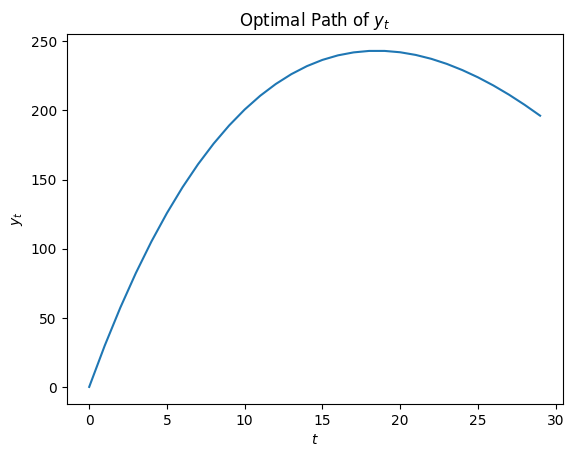

In [ ]:
T = 30
x0 = np.array([[0., 300., 1]]).T

x_path = lq_dp.compute_sequence(x0, ts_length=T)[0]

fig, ax = plt.subplots()
ax.plot(range(T), x_path[0, :-1])
ax.set_xlabel("$t$")
ax.set_ylabel("$y_t$")
ax.set_title("Optimal Path of $y_t$")
plt.show()

## **3**

Actual Law of Motion:

$$u=-Fx=-F\begin{bmatrix}y\\Y\\1\end{bmatrix}$$
$$u=y^{\prime}-y \longrightarrow h(y,Y)=y-Fx=y-F_{1}y-F_{2}Y-F_{3}$$
$$H_{A}(Y)=nh(\frac{Y}{n},Y)=n(\frac{Y}{n}-F_{1}\frac{Y}{n}-F_{2}Y-F_{3})$$
$$\longrightarrow H_{0}=-F_{3},\quad H_{1}=1-\frac{F_{1}}{n}-F_{2}$$

In [ ]:
n = 100

eps = 1e-5
max_iter = 1000
error = np.inf

In [ ]:
def calculate_actual_law_of_motion(policy_F, n):
    H0 = -policy_F[0, 2]
    H1 = 1-policy_F[0, 0]/n - policy_F[0, 1]
    return H0, H1

## **4**

In [ ]:
iteration = 0
F_current = np.zeros_like(F)

while error > eps and iteration <= max_iter:

    lq_dp, F = LQDP(Q, R, A, B, C, N, beta)

    F_last = F_current
    F_current = F

    H0_prime, H1_prime = calculate_actual_law_of_motion(F_current, n)

    A = np.array(
        [
            [1, 0, 0],
            [0, H1_prime, H0_prime],
            [0, 0, 1]
        ]
    )

    error = np.linalg.norm(F_current - F_last)

    iteration += 1

In [ ]:
print(f"H0:  {H0_prime:.4f}")
print(f"H1:  {H1_prime:.5f}")

H0:  57.8060
H1:  0.96382


## **5**

**Social Planner:**
$$V(Y)=\max_{Y^{\prime}} \{(A_{0}-A_{1}Y-c)Y-(Y^{\prime}-Y)-0.5d(Y^{\prime}-Y)^{2}+\beta V(Y^{\prime})\}$$
$$x_{t}=\begin{bmatrix}Y_{t}\\1\end{bmatrix}$$
$$u_{t}=Y_{t+1}-Y_{t}=Y^{\prime}-Y$$
$$R=\begin{bmatrix} -A_{1}& \frac{A_{0}-c}{2}\\ \frac{A_{0}-c}{2}&0 \end{bmatrix} \qquad Q=-0.5d \qquad N=\begin{bmatrix} 0,&1\end{bmatrix}$$

$$\begin{bmatrix}Y_{t+1}\\1\end{bmatrix}=\begin{bmatrix}1&0\\0&1 \end{bmatrix} \begin{bmatrix} Y_{t}\\1 \end{bmatrix}+ \begin{bmatrix}1\\0\end{bmatrix}u_{t} $$
$$\longrightarrow A=\begin{bmatrix}1&0\\0&1 \end{bmatrix} \qquad B = \begin{bmatrix}1&0 \end{bmatrix} $$

$$u =-Fx\longrightarrow Y^{\prime}= Y-F_{0}Y-F_{1} $$
$$\longrightarrow  H_{0} = -F_{1}, \qquad H_{1} = 1- F_{0}$$

In [ ]:
A = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)

B = np.array(
    [
        [1],
        [0],
    ]
)

R = np.array(
    [
        [-A1, (A0-c)/2],
        [(A0-c)/2, 0]
    ]
)/n

Q = np.array(
    [-0.5*d]
)/(n**2)

N = np.array(
    [
        [0, -1],
    ]
)/n

In [ ]:
lq_dp, F = LQDP(Q, R, A, B, None, N, beta)

H0 = -F[0, 1]
H1 = 1 - F[0, 0]

print(f"H0:  {H0:.4f}")
print(f"H1:  {H1:.6f}")

H0:  425.4771
H1:  0.467453


We know that the iteration method works based on equating the $H_A$ and $H$. We also know that this transformation is not a contraction and does not necessarily converge to a unique solution.


On the other hand, the social planner method based on Pareto efficiency first solves the problem of total firms to obtain H(Y) directly.


As can be seen in the results, the results of these two methods have not reached the same answer.

## **7**

In [ ]:
A = np.array(
    [
        [1, 0, 0],
        [0, H1_prime, H0_prime],
        [0, 0, 1]
    ]
)

B = np.array(
    [
        [1],
        [0],
        [0]
    ]
)

C = np.array(
    [
        [0],
        [sigma],
        [0]
    ]
)

R = -np.array(
    [
        [0, -A1/2, (A0-c)/2],
        [-A1/2, 0, 0],
        [(A0-c)/2, 0, 0]
    ]
)

Q = -np.array(
    [-0.5*d]
)

N = -np.array(
    [
        [0, 0, -1],
    ]
)

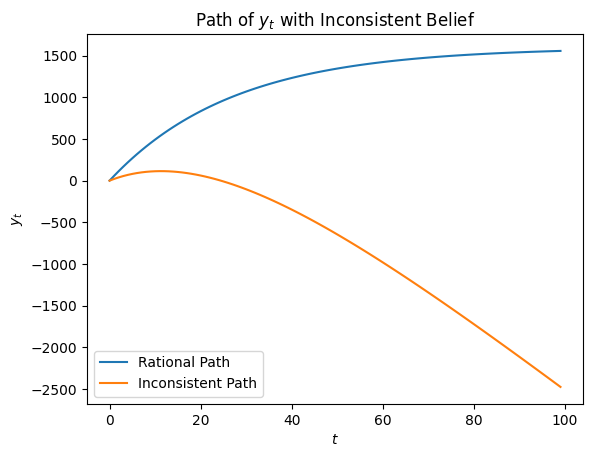

In [ ]:
T = 100
x0 = np.array([[0., 0., 1]]).T


H0_inconsistent = 100
H1_inconsistent = 0.97

A_inconsistent = np.array(
    [
        [1, 0, 0],
        [0, H1_inconsistent, H0_inconsistent],
        [0, 0, 1]
    ]
)

lq_dp, F = LQDP(Q, R, A_inconsistent, B, None, N, beta)
lq_dp.A = A
x_path_inconsistent = lq_dp.compute_sequence(x0, ts_length=T)[0]

lq_dp, F = LQDP(Q, R, A, B, None, N, beta)
x_path = lq_dp.compute_sequence(x0, ts_length=T)[0]

fig, ax = plt.subplots()
ax.plot(range(T), x_path[0, :-1], label="Rational Path")
ax.plot(range(T), x_path_inconsistent[0, :-1],  label="Inconsistent Path")
ax.set_xlabel("$t$")
ax.set_ylabel("$y_t$")
ax.set_title("Path of $y_t$ with Inconsistent Belief")
ax.legend()
plt.show()

# **2. Borrowing Constraint**

Consider the standard borrowing constraint problem of a household who faces i.i.d income shocks and has $x = a +e$ cash at hand:


$$V(x)=\max_{a^{\prime}}\{u(c)+\beta E[V(a^{\prime}+e^{\prime})]\}$$
$$s.t.  \quad \underline{a} \leq a^{\prime} = (1+r)(x-c) $$
$$c\geq 0$$

Suppose the income shocks take two values $e_{l}$, $e_{h}$ with probabilities $\pi$, $1-\pi$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import fminbound
from scipy.optimize import minimize_scalar
from numpy import interp

In [ ]:
def Utility(c, sigma=0.8):
    if c <= 0:
        return -np.inf
    else:
        return (c**(1-sigma))/(1-sigma)


In [ ]:
def bellman_operator(w, grid, beta, r, borrowing_constraint, utility, shocks, x_max):
  w_func = lambda x: interp(x, grid, w)
  Tw = np.empty(len(w))
  Policy = np.empty(grid_size)
  for i, x in enumerate(grid):
    objective =  lambda c: - (utility(c) + beta *np.mean(w_func((1+r)*(x-c) + shocks)))
    c_star = fminbound(objective, 1e-10, x-(borrowing_constraint)/(1+r))
    a_prime = (1+r)*(x-c_star)
    if a_prime < borrowing_constraint:
      consumption = x-(borrowing_constraint)/(1+r)
      Tw[i] = -objective(consumption)
      Policy[i] = borrowing_constraint
    else:
      Tw[i] = -objective(c_star)
      Policy[i] = a_prime
  return Tw, Policy

In [ ]:
def VFI_with_transition_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint):
  w = np.full(len(grid), 0.01)
  w_new = np.zeros_like(w)
  Tw = np.empty(len(grid))
  iter = 0
  i = 0
  error = 1
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))
  while error > tolerance and iter < max_iter:
    w = w_new
    w_new, Policy = bellman_operator(w, grid, beta, r, borrowing_constraint, Utility, shocks, x_max)
    # Replace -inf values with a large finite value
    w[np.isneginf(w)] = np.nanmax(w[np.isfinite(w)])
    w_new[np.isneginf(w_new)] = np.nanmax(w_new[np.isfinite(w_new)])
    # Calculate error
    error = np.nanmax(np.abs(w - w_new))
    axes[0].plot(grid, w, lw=2, alpha=0.6)
    axes[1].plot(grid, Policy, lw=2, alpha=0.6)
    axes[1].set_yticks(np.linspace(min(Policy), max(Policy), num=5))
    axes[1].set_xlabel('a')
    axes[1].set_ylabel('a prime')
    plt.subplots_adjust(hspace=0.4)
    iter += 1
    i += 1
  plt.show()

In [ ]:
def VFI_without_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint, shocks):
  w = np.full(len(grid), 0.01)
  w_new = np.zeros_like(w)
  Tw = np.empty(len(grid))
  iter = 0
  i = 0
  error = 1
  while error > tolerance and iter < max_iter:
    w = w_new
    w_new, Policy = bellman_operator(w, grid, beta, r, borrowing_constraint, Utility, shocks, x_max)
    # Replace -inf values with a large finite value
    w[np.isneginf(w)] = np.nanmax(w[np.isfinite(w)])
    w_new[np.isneginf(w_new)] = np.nanmax(w_new[np.isfinite(w_new)])
    # Calculate error
    error = np.nanmax(np.abs(w - w_new))
    iter += 1
    i += 1
  Value_function = w_new
  Policy_function = Policy
  return Value_function, Policy_function

In [ ]:
def Shock_generator(R, p, e_l, e_h):
  # shocks
  np.random.seed(1403)
  n_trials = R # Number of trials
  P = p  # Probability of success
  # Generate 500 random Bernoulli trials
  shock = np.random.binomial(1, P, n_trials)
  shocks = np.where(shock == 1, e_l, e_h)
  return shocks


In [ ]:
# grid
grid_min = -0.2
grid_max = 5
grid_size = 300
grid = np.linspace(grid_min, grid_max, grid_size)

beta = 0.85
r = 0.15
borrowing_constraint = -0.25

# shocks
low_shock = 0.5
high_shock = 1.5
R = 150
p = 0.3

x_max = grid_max

max_iter = 1000
tolerance = 1e-6

In [ ]:
shocks = Shock_generator(R, p, low_shock, high_shock)

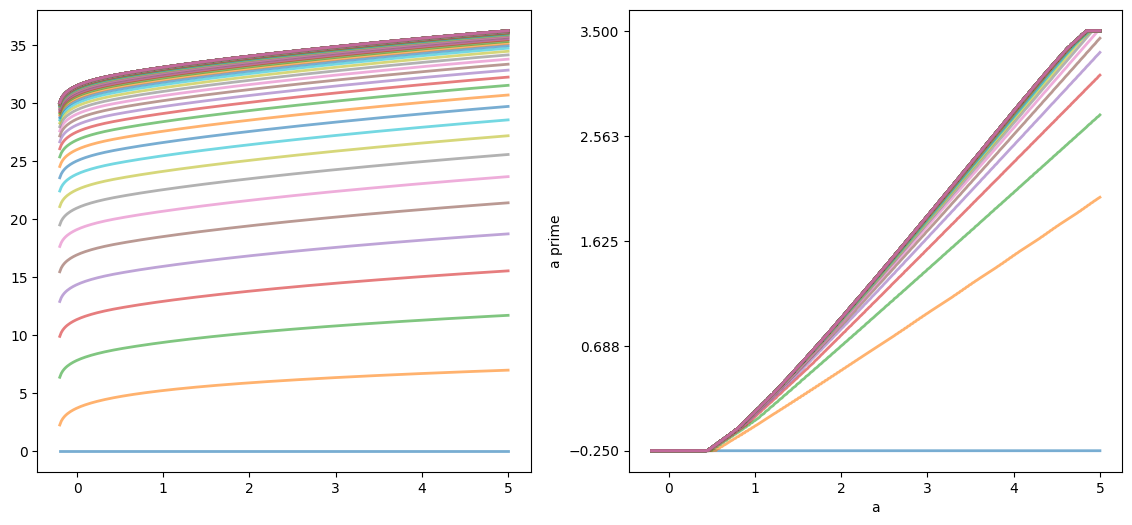

In [ ]:
VFI_with_transition_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint)

**with different $\underline{a}$**

In [ ]:
borrowing_constraint_1 = -0.25
V_1, A_1 = VFI_without_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint_1, shocks)
borrowing_constraint_2 = -0.4
V_2, A_2 = VFI_without_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint_2, shocks)

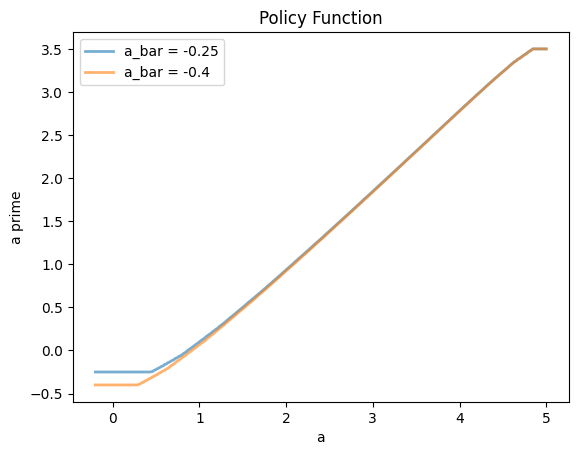

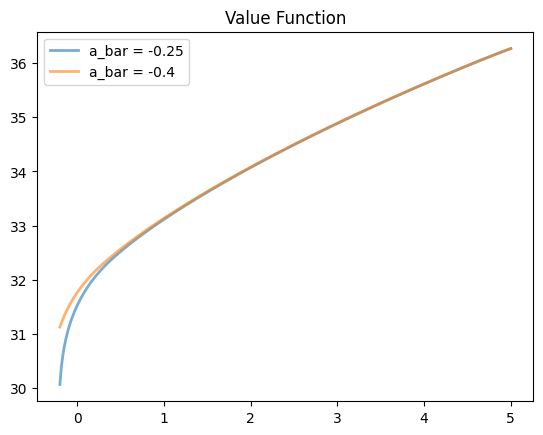

In [ ]:
# Policy function
plt.plot(grid, A_1, lw=2, alpha=0.6, label='a_bar = -0.25')
plt.plot(grid, A_2, lw=2, alpha=0.6, label='a_bar = -0.4')
plt.xlabel('a')
plt.ylabel('a prime')
plt.title("Policy Function")
plt.legend()
plt.show()

# value function
plt.plot(grid, V_1, lw=2, alpha=0.6, label='a_bar = -0.25')
plt.plot(grid, V_2, lw=2, alpha=0.6, label='a_bar = -0.4')
plt.title("Value Function")
plt.legend()
plt.show()

**Different $\beta$**

In [ ]:
beta_1 = 0.8
V_2_1, A_2_1 = VFI_without_plot(tolerance, max_iter, grid, beta_1, r, borrowing_constraint, shocks)
beta_2 = 0.95
V_2_2, A_2_2 = VFI_without_plot(tolerance, max_iter, grid, beta_2, r, borrowing_constraint, shocks)

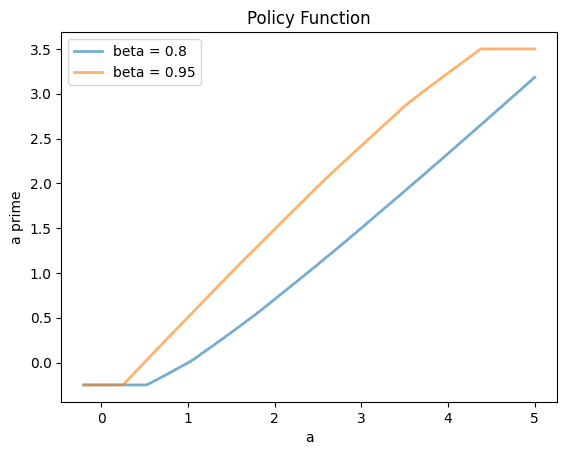

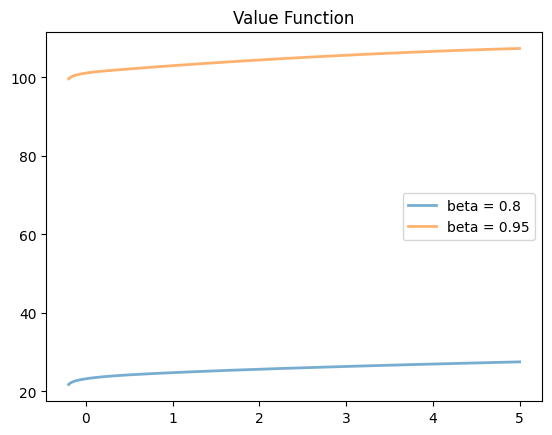

In [ ]:
# Policy function
plt.plot(grid, A_2_1, lw=2, alpha=0.6, label='beta = 0.8')
plt.plot(grid, A_2_2, lw=2, alpha=0.6, label='beta = 0.95')
plt.xlabel('a')
plt.ylabel('a prime')
plt.title("Policy Function")
plt.legend()
plt.show()

# value function
plt.plot(grid, V_2_1, lw=2, alpha=0.6, label='beta = 0.8')
plt.plot(grid, V_2_2, lw=2, alpha=0.6, label='beta = 0.95')
plt.title("Value Function")
plt.legend()
plt.show()

**Different r**

In [ ]:
r_1 = 0.2
V_3_1, A_3_1 = VFI_without_plot(tolerance, max_iter, grid, beta, r_1, borrowing_constraint, shocks)
r_2 = 0.07
V_3_2, A_3_2 = VFI_without_plot(tolerance, max_iter, grid, beta, r_2, borrowing_constraint, shocks)

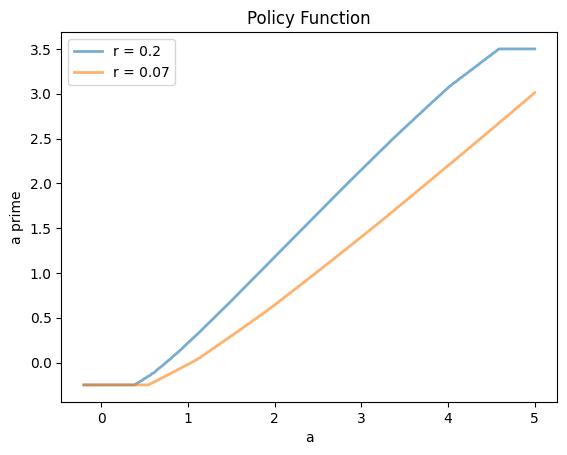

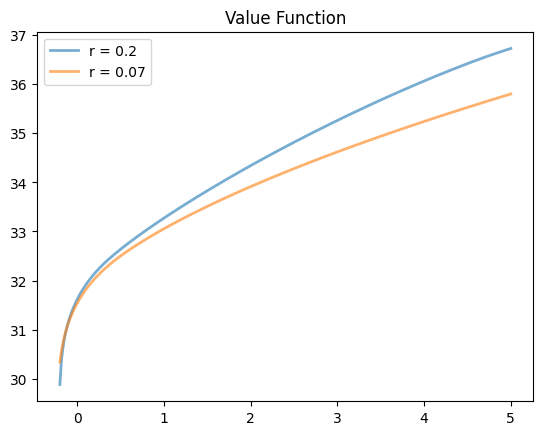

In [ ]:
# Policy function
plt.plot(grid, A_3_1, lw=2, alpha=0.6, label='r = 0.2')
plt.plot(grid, A_3_2, lw=2, alpha=0.6, label='r = 0.07')
plt.xlabel('a')
plt.ylabel('a prime')
plt.title("Policy Function")
plt.legend()
plt.show()

# value function
plt.plot(grid, V_3_1, lw=2, alpha=0.6, label='r = 0.2')
plt.plot(grid, V_3_2, lw=2, alpha=0.6, label='r = 0.07')
plt.title("Value Function")
plt.legend()
plt.show()

**Different Pi**

In [ ]:
# shocks
low_shock = 0.5
high_shock = 1.5
R = 150
p_1 = 0.2
p_2 = 0.5
shocks_1 = Shock_generator(R, p_1, low_shock, high_shock)
V_4_1, A_4_1 = VFI_without_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint, shocks_1)
shocks_2 = Shock_generator(R, p_2, low_shock, high_shock)
V_4_2, A_4_2 = VFI_without_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint, shocks_2)


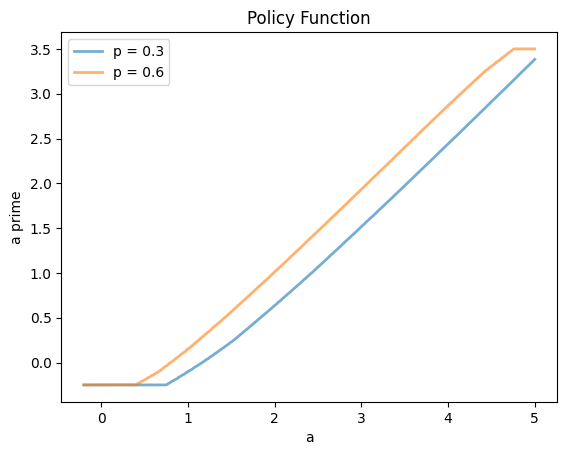

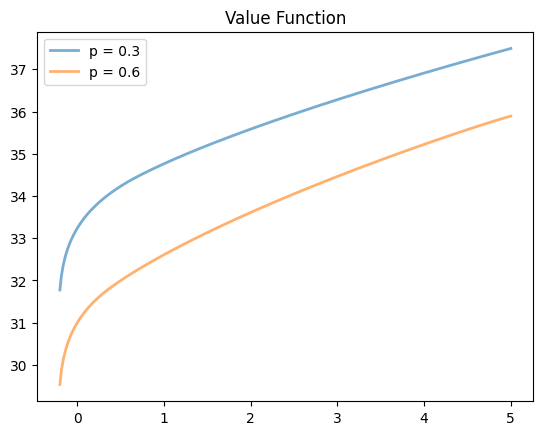

In [ ]:
# Policy function
plt.plot(grid, A_4_1, lw=2, alpha=0.6, label='p = 0.3')
plt.plot(grid, A_4_2, lw=2, alpha=0.6, label='p = 0.6')
plt.xlabel('a')
plt.ylabel('a prime')
plt.title("Policy Function")
plt.legend()
plt.show()

# value function
plt.plot(grid, V_4_1, lw=2, alpha=0.6, label='p = 0.3')
plt.plot(grid, V_4_2, lw=2, alpha=0.6, label='p = 0.6')
plt.title("Value Function")
plt.legend()
plt.show()

**Different E[e]**

In [ ]:
# shocks
low_shock_1 = 0.5
high_shock_1 = 1.5

low_shock_2 = 0.5
high_shock_2 = 3

R = 150
shocks_2_1 = Shock_generator(R, p, low_shock_1, high_shock_1)
V_5_1, A_5_1 = VFI_without_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint, shocks_2_1)
shocks_2_2 = Shock_generator(R, p, low_shock_2, high_shock_2)
V_5_2, A_5_2 = VFI_without_plot(tolerance, max_iter, grid, beta, r, borrowing_constraint, shocks_2_2)

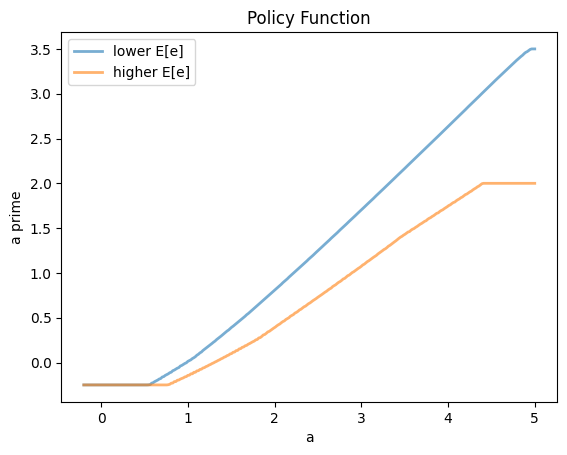

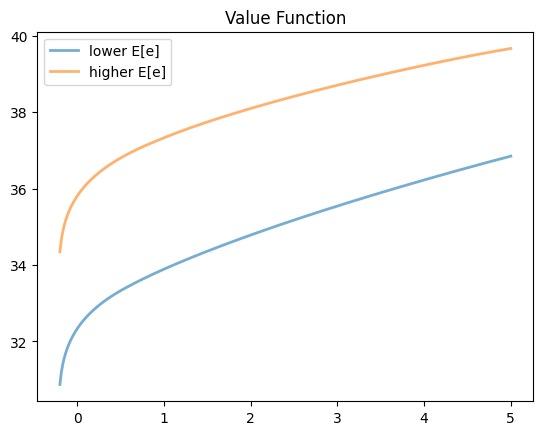

In [ ]:
# Policy function
plt.plot(grid, A_5_1, lw=2, alpha=0.6, label='lower E[e]')
plt.plot(grid, A_5_2, lw=2, alpha=0.6, label='higher E[e]')
plt.xlabel('a')
plt.ylabel('a prime')
plt.title("Policy Function")
plt.legend()
plt.show()

# value function
plt.plot(grid, V_5_1, lw=2, alpha=0.6, label='lower E[e]')
plt.plot(grid, V_5_2, lw=2, alpha=0.6, label='higher E[e]')
plt.title("Value Function")
plt.legend()
plt.show()

**intuitions**

As the borrowing constraint tightens (with an increase in a_bar), the household gains less flexibility in smoothing its consumption by borrowing against lower income levels. With a tighter constraint, the policy function hits its constraint at higher levels, limiting the household's ability to smooth consumption effectively. Consequently, as consumption smoothing decreases due to the constraint, the agent's utility cannot attain its optimum level. This results in a lower value function where the borrowing constraint becomes binding.

As the discount factor decreases, households exhibit less patience, indicating a stronger preference for present consumption over future consumption. Consequently, this preference shift leads to higher current consumption and lower savings. However, due to the presence of a borrowing constraint, households cannot fully smooth their consumption trajectory. Consequently, less patient households reach their borrowing constraint at higher asset levels. Additionally, the value function tends to be higher for more patient households, reflecting their ability to accumulate higher savings and engage in more substantial consumption, compared to less patient counterparts.

Similarly, an elevated interest rate amplifies the opportunity cost associated with present consumption, prompting individuals to prioritize saving for the future. Consequently, higher savings and reduced current consumption levels emerge as borrowing costs escalate. In this scenario, individuals are less inclined to borrow, contributing to the attainment of the binding constraint at lower asset levels. Furthermore, as savings escalate, the value function ascends correspondingly.

An elevated probability of encountering a low-income shock heightens the need for precautionary savings, prompting individuals to increase their overall savings and reduce consumption. Consequently, individuals with higher precautionary savings encounter the binding constraint at lower asset levels. Additionally, due to the presence of precautionary savings, consumption levels diminish, resulting in a lower value function.

Increased mean income shocks usually correspond to higher overall consumption since households anticipate greater future income and can consequently afford increased present consumption. This mirrors the previous scenario, where higher expected income reduces the need for precautionary savings, resulting in higher consumption and lifetime utility. Moreover, individuals would prefer to smooth consumption through borrowing rather than relying on precautionary savings, accelerating their approach towards the borrowing constraint.